# 194.049 Energy-efficient Distributed Systems
## Assignment Part 2: Simulation infrastructure and preliminary implementation
### Gent Rexha (11832486), Princ Mullatahiri (11846033), Ilir Osmanaj (11770999)
#### 29.05.2019

In [4]:
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
from pathlib import Path
from keras import Sequential
from keras.layers import LSTM, Dense
from matplotlib import pyplot
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from plotnine import *

Using TensorFlow backend.


## Preprocessment

In [20]:
import platform
if platform.system() == 'Darwin':
    data_path = Path('../data')
else:
    data_path = Path('C:/Projects/University/Semester 2 Projects/Energy-efficient Distributed Systems/energy_efficient_ds/Assignment P3/data')

### Data Preparation

In [24]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

df = pd.read_csv(data_path / 'poll.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)

# Manually specify column names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'

# Mark all NA values with 0
df['pollution'].fillna(0, inplace=True)

# Drop the first 24 hours because all of them have missing values
df = df[24:]

# Summarize first 5 rows
display(df.head())

# Save to file
df.to_csv(data_path / 'pollution.csv')

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [25]:
import random
from copy import deepcopy

# Select only temp and first year for forecast
df_pred = df.loc[:, ['temp']]
df_pred = df_pred.iloc[0:24*7*52]


def create_gap(df, number_of_gaps: int = 1, seed: int = None):
    """Creates a artificial made gap in the first column of the dataset with a size from 50-100.
    
    Args:
        df (pd.Dataframe): dataframe where the gap should be created
    
    Output:
        dataset (pd.Dataframe): dataframe with random gap
    """
    dataset = deepcopy(df)
    already_created_gap = set()
    gap_ranges= []
    
    if seed:
        random.seed(seed)
    
    for i in range(0, number_of_gaps):
        gap_is_valid = False
        
        # try to re-generate the gap so that its not in the same range
        while not gap_is_valid:
            gap_start = random.randint(0, len(df.index))
            gap_size = random.randint(50,100)
            # all indexes generated should not be in the greated gap 
            # we make sure to not overwrite the same gap twice
            gap_is_valid = all([i not in already_created_gap] for i in range(gap_start, gap_size))
            
            if gap_is_valid:
                dataset.iloc[gap_start : gap_start + gap_size] = np.nan
                # store the created gap ranges
                gap_ranges.append((gap_start, gap_start + gap_size))

    return dataset, gap_ranges


df_gap, gap_ranges = create_gap(df_pred, number_of_gaps=3)

### Visualizations

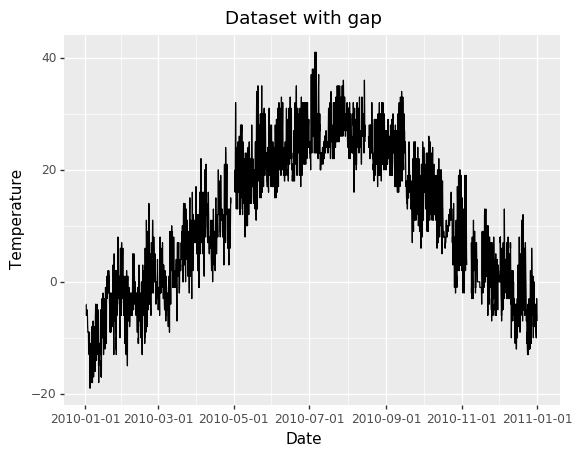

<ggplot: (-9223371885889598243)>


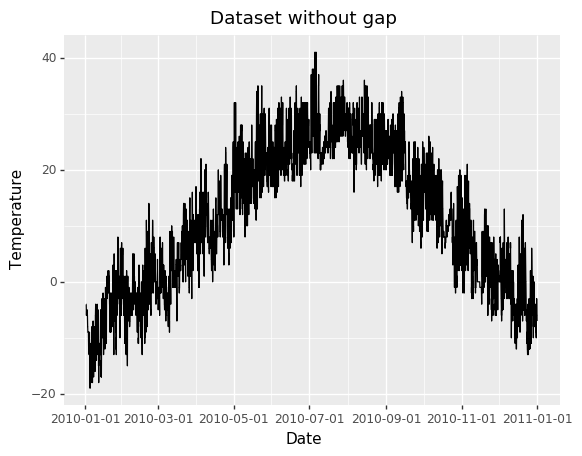

<ggplot: (-9223371885889487237)>


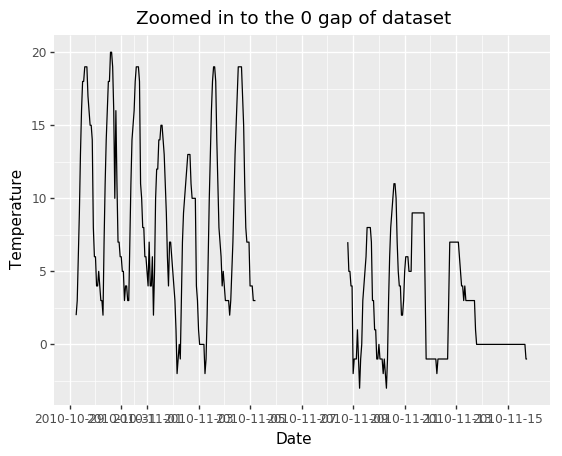

<ggplot: (150963485830)>


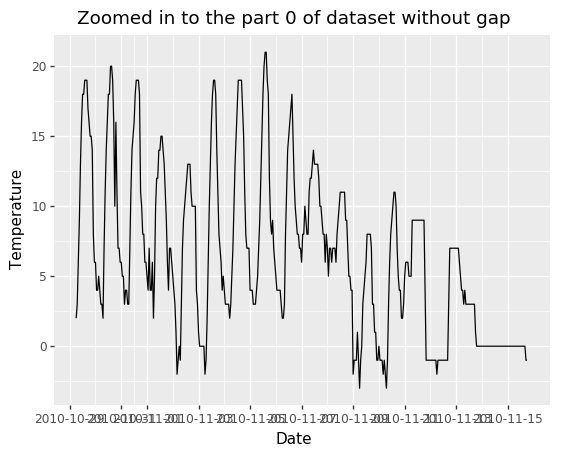

<ggplot: (150965345677)>


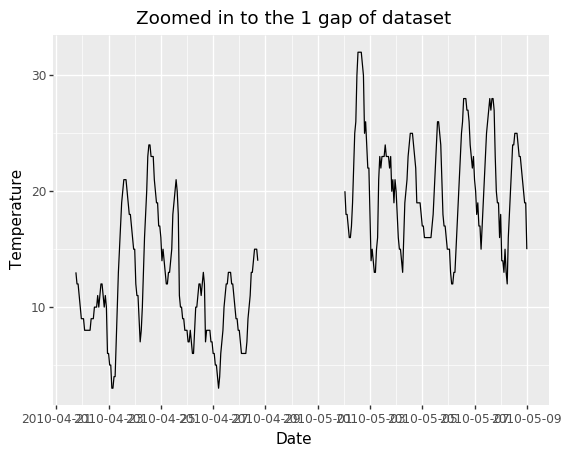

<ggplot: (-9223371885888160175)>


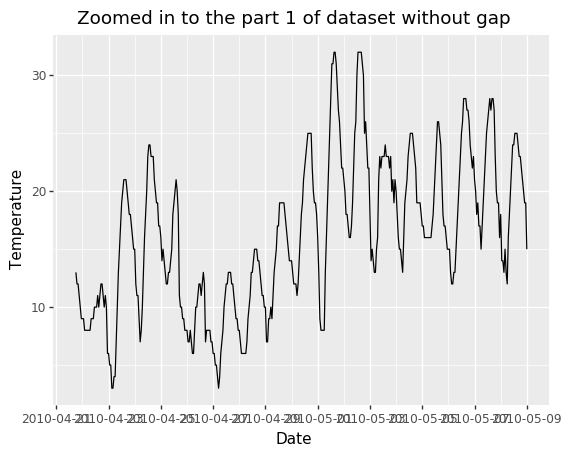

<ggplot: (-9223371885888122592)>


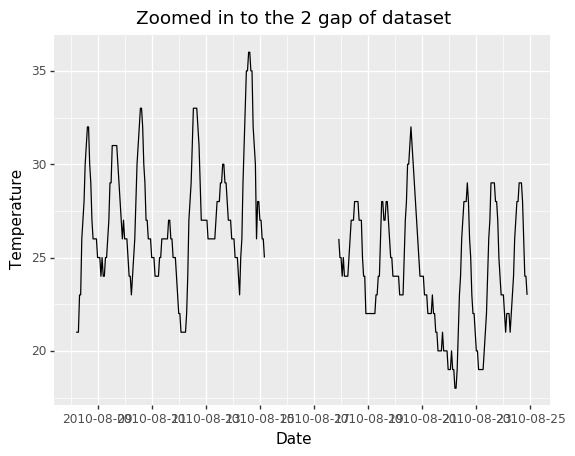

<ggplot: (-9223371885888090557)>


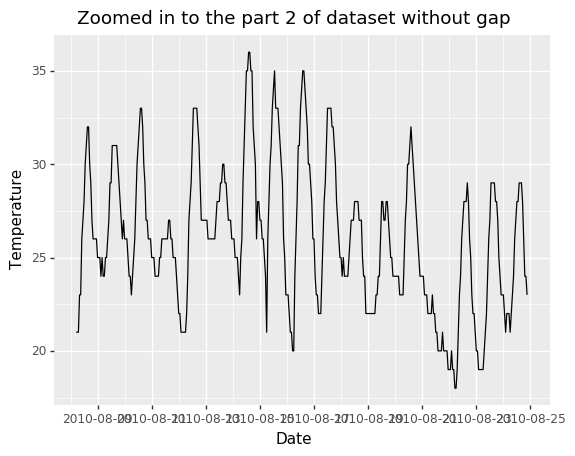

<ggplot: (150966625656)>


In [14]:
# df_gap
g1 = ggplot(df_gap, 
            aes('df_gap.index', 'temp')) + \
            geom_line() + labs(x='Date', y='Temperature', title='Dataset with gap')
print(g1)

# df_pred
g2 = ggplot(df_pred, 
            aes('df_pred.index', 'temp')) + \
            geom_line() + labs(x='Date', y='Temperature', title='Dataset without gap')
print(g2)

one_week_interval = 24*7
# Zoomed in version of df_gap
for i, gap_range in enumerate(gap_ranges):
    dataset = df_gap.iloc[gap_range[0] - one_week_interval : gap_range[1] + one_week_interval]
    g3 = ggplot(dataset, 
                aes('dataset.index', 'temp')) + \
                geom_line() + labs(x='Date', y='Temperature', title='Zoomed in to the {} gap of dataset'.format(i))
    print(g3)

    # Zoomed in version of df_pred
    dataset = df_pred.iloc[gap_range[0]-one_week_interval : gap_range[1] + one_week_interval]
    g4 = ggplot(dataset, 
                aes('dataset.index', 'temp')) + \
                geom_line() + labs(x='Date', y='Temperature', title='Zoomed in to the part {} of dataset without gap'.format(i))
    print(g4)

In [15]:
import pandas as pd
from fbprophet import Prophet

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [26]:
# Prepare df for prophet
df_gap.reset_index(level=0, inplace=True)
df_gap = df_gap.rename(index=str, columns={"index": "date"})
df_gap = df_gap.rename(index=str, columns={"date": "ds", "temp": "y"})
df_gap.head()

,ds,y
0,2010-01-02 00:00:00,-4.0
1,2010-01-02 01:00:00,-4.0
2,2010-01-02 02:00:00,-5.0
3,2010-01-02 03:00:00,-5.0
4,2010-01-02 04:00:00,-5.0


In [41]:
m = Prophet()
m.fit(df_gap)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second a

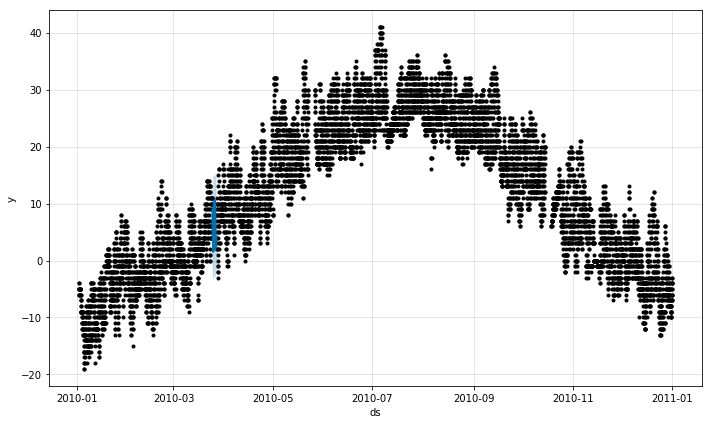

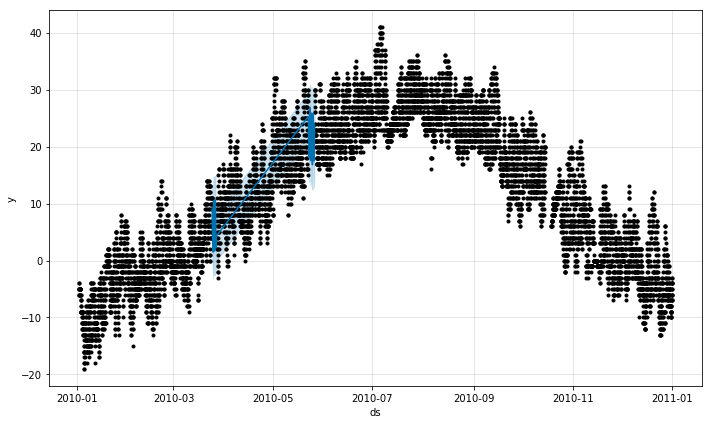

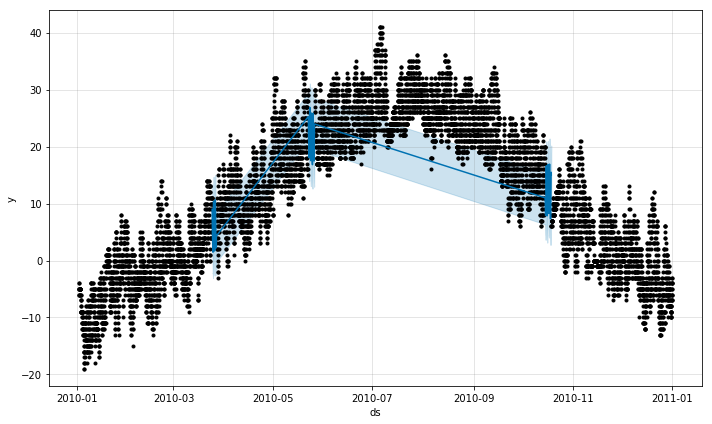

In [49]:
# future = pd.DataFrame(columns=['ds', 'y'])
# Get rows from df_gap
for i, gap_range in enumerate(gap_ranges):
    dataset = df_gap.iloc[gap_range[0]:gap_range[1]]
    forecast = m.predict(dataset)
    fig1 = m.plot(forecast)
   #  future = pd.concat([future, dataset])

#display(future.head())

In [43]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
241,2010-10-18 12:00:00,14.185680,9.386885,18.505852
242,2010-10-18 13:00:00,14.875954,10.423241,19.137721
243,2010-10-18 14:00:00,15.354759,10.738951,19.664931
244,2010-10-18 15:00:00,15.482569,11.208663,19.707306
245,2010-10-18 16:00:00,15.094012,10.690055,19.486021


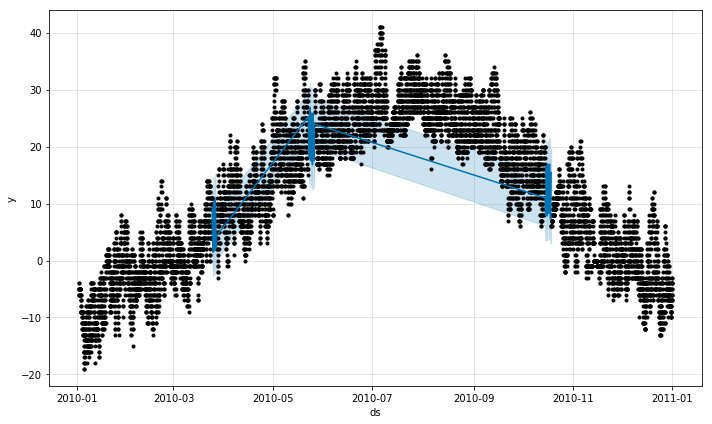

In [44]:
fig1 = m.plot(forecast)

In [18]:
def perfrom_scaling(values):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(values)

### Label Enconding & Scaling

In [19]:
# Load dataset
values = df_gap.values
values_original = df_pred.values

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
values_original = scaler.fit_transform(values_original)

# Encoded & scaled values
display(values)

array([[0.25      ],
       [0.25      ],
       [0.23333333],
       ...,
       [0.21666667],
       [0.2       ],
       [0.2       ]])

### Transforming Time Series Data into a Supervised Machine Learning Problem

In [20]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """Frame a time series as a supervised learning dataset.
    
    Args:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        pd.Dataframe: The return value. True for success, False otherwise.
    
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = deepcopy(pd.DataFrame(data))
    cols = list()
    names = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    return agg

In [21]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)[1:]
reframed_original = series_to_supervised(values_original, 1, 1)[1:]
print(reframed.head())

   var1(t-1)   var1(t)
1   0.250000  0.250000
2   0.250000  0.233333
3   0.233333  0.233333
4   0.233333  0.233333
5   0.233333  0.216667


In [27]:
values = reframed.values
values_original = reframed_original.values

# concatinate all non-gap data in one variable
all_merged = []
for gap_range in gap_ranges:
    all_merged.append(values[1:gap_range[0] + 1, :])
    all_merged.append(values[gap_range[1]:, :])
    
all_data = np.concatenate(all_merged)

# use most of the data as train, and from 100 to 200 for testing
train = all_data[list(range(0, 100)) + list(range(200, all_data.shape[0] - 1)),:][:10000]
# train = all_data[list(range(0, 100)),:]
validation = all_data[list(range(100, 200)),:]

# test contains only data from the gap (but we use the orignal dataset - since they are not none)
original_gaps_merged = [] 
for gap_range in gap_ranges:
    original_gaps_merged.append(values_original[gap_range[0]: gap_range[1], :])
    
test = np.concatenate(original_gaps_merged)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
validation_X, validation_y = validation[:, :-1], validation[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape)

(10000, 1, 1) (10000,) (100, 1, 1) (100,)


In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=1, 
                    validation_data=(validation_X, validation_y), verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 10000 samples, validate on 100 samples
Epoch 1/10


In [24]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Gap RMSE: %.3f' % rmse)

Gap RMSE: 5.152


### Visualizing predicted vs actual values

[(7608, 7685), (3644, 3695), (7554, 7625)]
77


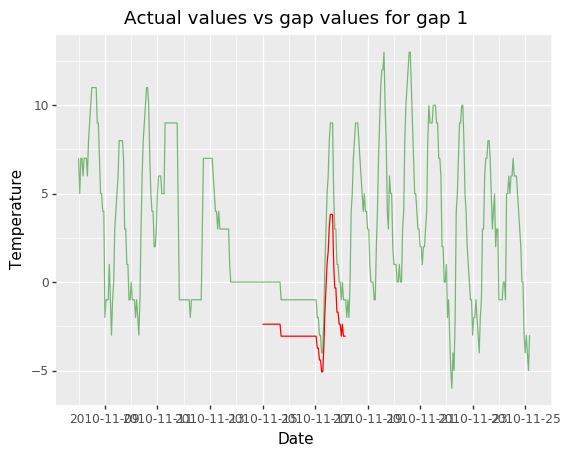

<ggplot: (126918669751)>
51


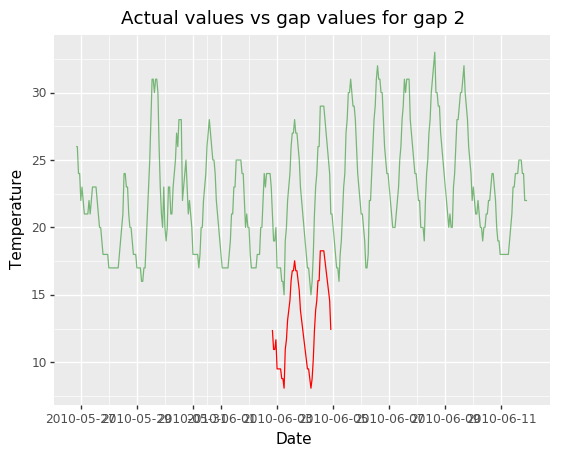

<ggplot: (-9223371909936041840)>
71


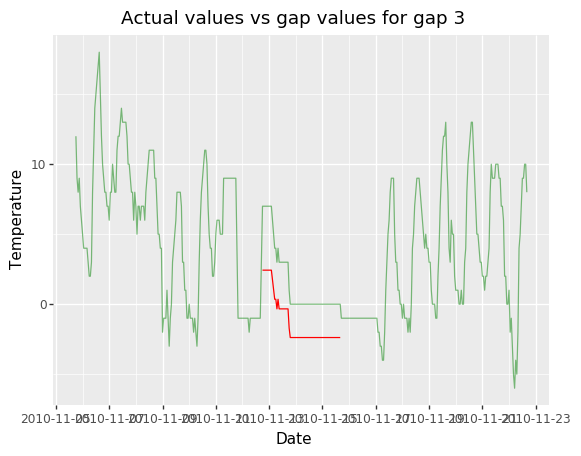

<ggplot: (-9223371909945591692)>


In [25]:
# Insert predicted values into df_gap
print(gap_ranges)
for i, gap_range in enumerate(gap_ranges):
    # some magic to know where to fetch the yhat for each gap_range
    start_in_yhat = 0 if i == 0 else sum(c[1] - c[0] for c in gap_ranges[:i])
    
    print(len(inv_yhat[start_in_yhat: start_in_yhat + (gap_range[1] - gap_range[0])]))
    df_gap.iloc[gap_range[0] : gap_range[1], 0] = inv_yhat[start_in_yhat: start_in_yhat + (gap_range[1] - gap_range[0])]
    
    df1 = df_gap.iloc[gap_range[0] : gap_range[1]]
    df2 = df_pred.iloc[gap_range[0] - one_week_interval : gap_range[1] + one_week_interval]

    g1 = ggplot() + \
         geom_line(df1, aes('df1.index', 'temp'), color='red') + \
         geom_line(df2, aes('df2.index', 'temp'), color='green', alpha=0.5) + \
        labs(x='Date', y='Temperature', title='Actual values vs gap values for gap {}'.format(i + 1))
    print(g1)